***
# **Classificação de Assuntos Processuais** <img src="https://cdn-icons-png.flaticon.com/512/3292/3292568.png" width="3%">
***

Neste projeto, vamos classificar o assunto processual de acordo com o texto da sua petição inicial. O grande objetivo por trás disso será evitar que o advogado possa errar o assunto ao qual submete esse processo, e que seja gasto tempo dos servidores lendo a petição inicial e corrigindo seu devido assunto para que ele tenha seu trâmite ocorra de forma correta. 

<br>
<p align=center>
<img src="https://cdn-icons-png.flaticon.com/512/2912/2912872.png" width="30%"></p>
<br>

Esse projeto se ganha importância quando vemos a quantidade de processos abertos por ano. A Justiça abriu <a href="https://itforum.com.br/noticias/um-terco-dos-brasileiros-ja-foi-vitima-de-fraude-com-cartao-de-credito-diz-ibm/">27,7 milhões</a> de novos casos em 2021, alta de 10,4% em relação ao observado em 2020. O dado faz parte do relatório “Justiça em Números”. Considerando somente as ações ajuizadas pela primeira vez em 2021, o número vai para 19,1 milhões de novos processos.

Esse projeto não vai acabar de vez com a morosidade da justiça, mas faz parte de um pequeno esforço dentro de tantos outros esforços que prometem contribuir cada vez mais por uma justiça melhor. 


***
## **Carregamento de dependências** <img src="https://cdn-icons-png.flaticon.com/512/4461/4461808.png" width="3%">
***

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!sudo apt install build-essential libpoppler-cpp-dev pkg-config python3-dev -q

Reading package lists...
Building dependency tree...
Reading state information...
pkg-config is already the newest version (0.29.1-0ubuntu4).
python3-dev is already the newest version (3.8.2-0ubuntu2).
python3-dev set to manually installed.
build-essential is already the newest version (12.8ubuntu1.1).
The following additional packages will be installed:
  libpoppler-cpp0v5
The following NEW packages will be installed:
  libpoppler-cpp-dev libpoppler-cpp0v5
0 upgraded, 2 newly installed, 0 to remove and 23 not upgraded.
Need to get 46.0 kB of archives.
After this operation, 223 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 libpoppler-cpp0v5 amd64 0.86.1-0ubuntu1.1 [35.6 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 libpoppler-cpp-dev amd64 0.86.1-0ubuntu1.1 [10.4 kB]
Fetched 46.0 kB in 0s (110 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the

In [3]:
!pip install pdftotext -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 KB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [47]:
import glob
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pdftotext
import re
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from xgboost import XGBClassifier



In [5]:
nltk.download('all')

stopwords = nltk.corpus.stopwords.words('portuguese')

stemmer = nltk.stem.RSLPStemmer()

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

In [6]:
# Adicionar mais palavras ao stopwords criado, verificando se já existe
new_stopwords = ['br', 'pág', 'listView', 'https', 'http', 'advogado', 'tabela', 'seguir', 'administrativo', 'processo',
                 'numbr','numbrª', 'ª', 'nº', 'juízo', 'Federal', 'ofício', 'geral', 'defensoria', 'pública', 'união',
                 'justiça', 'federal', 'região', 'pje', 'processo', 'judicial', 'vara', 'subseção', 'judiciária',
                 'juizado', 'especial' , 'cível', 'seção', 'excelentíssimo', 'senhor', 'doutor', 'juiz', 'acórdão',
                 'classe', 'procedimento', 'órgão', 'distribuição', 'excelentissimo', 'gerador', 'fato',
                 'brasileira', 'divorciada', 'servidora', 'cpf', 'residente', 'domiciliada', 'rua',
                 'constituído', 'através', 'procuração', 'anexo', 'vem', 'perante', 'vossa', 'excelência', 'todo', 'acato', 'ajuizar',
                 'presente', 'obrigação', 'fazer', 'pessoa', 'jurídica', 'direito', 'público', 'inscrita', 'cnpj', 'representada', 'localizada',
                 'estado', 'rio', 'grande', 'norte'] 
print(len(stopwords))
for word in new_stopwords:
  if word not in stopwords:
    stopwords.append(word)
print(len(stopwords))

207
285


***
## **Importando os documentos de petição** <img src="https://as2.ftcdn.net/v2/jpg/01/69/33/39/1000_F_169333910_pGApA6p8bYBGq0oNmJYJLOswGfCRZuxE.jpg" width="3%">
***

Foi realizado um trabalho manual dos servidores da justiça em que a cada petição inicial corrigida, a mesma era colocada em uma determinada pasta com o nome do assunto a qual ela pertencia. Devido a isso, foi feito uma engenharia em que foi criado o dataFrame a partir dessa separação de petições por pastas. 

No final, será gerado um arquivo csv para não rodar o script para gerar os dataFrames, e será trabalhado com esse arquivo CSV. Em caso de novas petições chegarem, o processo de gerar o nosso dataFrame poderar ser usado novamente, gerando um novo arquivo csv, ao qual substituiremos. 

In [ ]:
def transforma_dataframe(lista_arquivos, classe):
  lista_strings = []
  for peticao in lista_arquivos:
    with open(peticao, "rb") as f:
      pdf = pdftotext.PDF(f)
    lista_strings.append("\n\n".join(pdf))

  classificacao = []
  for i in range(len(lista_arquivos)):
    classificacao.append(classe)

  df = cria_dataframe(lista_arquivos, lista_strings, classificacao)
  return df

def cria_dataframe(lista_arquivos, lista_strings, classificacao):
  dicionario_peticao = {
    'nome_documento': lista_arquivos,
    'conteudo_peticao': lista_strings,
    'classificacao': classificacao,
  }
  
  df_peticao_inicial = pd.DataFrame(dicionario_peticao)
  return df_peticao_inicial

  

In [ ]:
lista_arquivos = []
for arquivo in glob.glob(r'/content/drive/MyDrive/trf5.peticoes/20 - AUXÍLIO-EMERGENCIAL/*pdf'):
  if arquivo not in lista_arquivos:
    lista_arquivos.append(arquivo)

df_auxilio_emergencial = transforma_dataframe(lista_arquivos, "auxilio_emergencial")

In [ ]:
lista_arquivos = []
for arquivo in glob.glob(r'/content/drive/MyDrive/trf5.peticoes/20 - SAÚDE - FORNECIMENTO DE MEDICAMENTOS/*pdf'):
  if arquivo not in lista_arquivos:
    lista_arquivos.append(arquivo)

df_fornecimento_medicamentos = transforma_dataframe(lista_arquivos, "fornecimento_medicamentos")

In [ ]:
lista_arquivos = []
for arquivo in glob.glob(r'/content/drive/MyDrive/trf5.peticoes/23 - TRIB - CONTR. PREV. PAGAS ALÉM DO TETO/*pdf'):
  if arquivo not in lista_arquivos:
    lista_arquivos.append(arquivo)

df_prev_pagas_alem_do_teto = transforma_dataframe(lista_arquivos, "prev_pagas_alem_do_teto")

In [ ]:
lista_arquivos = []
for arquivo in glob.glob(r'/content/drive/MyDrive/trf5.peticoes/25 - APOSENTADORIA POR TEMPO DE CONTRIBUICAO/*pdf'):
  if arquivo not in lista_arquivos:
    lista_arquivos.append(arquivo)

df_aposentadoria_tempo_contribuicao = transforma_dataframe(lista_arquivos, "aposentadoria_tempo_contribuicao")

In [ ]:
lista_arquivos = []
for arquivo in glob.glob(r'/content/drive/MyDrive/trf5.peticoes/25 - AUXILIO RECLUSAO/*pdf'):
  if arquivo not in lista_arquivos:
    lista_arquivos.append(arquivo)

df_auxilio_reclusao = transforma_dataframe(lista_arquivos, "auxilio_reclusao")

In [ ]:
lista_arquivos = []
for arquivo in glob.glob(r'/content/drive/MyDrive/trf5.peticoes/26 - ACAO COBRANCA DPVAT/*pdf'):
  if arquivo not in lista_arquivos:
    lista_arquivos.append(arquivo)

df_acao_cobranca_dpvat = transforma_dataframe(lista_arquivos, "acao_cobranca_dpvat")

In [ ]:
lista_arquivos = []
for arquivo in glob.glob(r'/content/drive/MyDrive/trf5.peticoes/28 - APOSENTADORIA POR IDADE URBANA/*pdf'):
  if arquivo not in lista_arquivos:
    lista_arquivos.append(arquivo)

df_aposent_idade_urbana = transforma_dataframe(lista_arquivos, "aposent_idade_urbana")

In [ ]:
lista_arquivos = []
for arquivo in glob.glob(r'/content/drive/MyDrive/trf5.peticoes/28 - SALARIO MATERNIDADE RURAL/*pdf'):
  if arquivo not in lista_arquivos:
    lista_arquivos.append(arquivo)

df_salario_maternid_rural = transforma_dataframe(lista_arquivos, "salario_maternid_rural")

In [ ]:
lista_arquivos = []
for arquivo in glob.glob(r'/content/drive/MyDrive/trf5.peticoes/29 - REVISIONAL FGTS/*pdf'):
  if arquivo not in lista_arquivos:
    lista_arquivos.append(arquivo)

df_revisional_fgts = transforma_dataframe(lista_arquivos, "revisional_fgts")

In [ ]:
lista_arquivos = []
for arquivo in glob.glob(r'/content/drive/MyDrive/trf5.peticoes/31 - SALARIO MATERNIDADE/*pdf'):
  if arquivo not in lista_arquivos:
    lista_arquivos.append(arquivo)

df_salario_maternidade = transforma_dataframe(lista_arquivos, "salario_maternidade")

In [ ]:
lista_arquivos = []
for arquivo in glob.glob(r'/content/drive/MyDrive/trf5.peticoes/33 - AUXÍLIO-DOENÇA E APOSENTADORIA POR INVALIDEZ/*pdf'):
  if arquivo not in lista_arquivos:
    lista_arquivos.append(arquivo)

df_aux_doenca_aposent_invalidez = transforma_dataframe(lista_arquivos, "aux_doenca_aposent_invalidez")

In [ ]:
lista_arquivos = []
for arquivo in glob.glob(r'/content/drive/MyDrive/trf5.peticoes/35 - PENSAO POR MORTE/*pdf'):
  if arquivo not in lista_arquivos:
    lista_arquivos.append(arquivo)

df_pensao_p_morte = transforma_dataframe(lista_arquivos, "pensao_p_morte")

In [ ]:
lista_arquivos = []
for arquivo in glob.glob(r'/content/drive/MyDrive/trf5.peticoes/45 - APOSENTADORIA IDADE RURAL/*pdf'):
  if arquivo not in lista_arquivos:
    lista_arquivos.append(arquivo)

df_aposen_idade_rural = transforma_dataframe(lista_arquivos, "aposen_idade_rural")

In [ ]:
lista_arquivos = []
for arquivo in glob.glob(r'/content/drive/MyDrive/trf5.peticoes/48 - APOSENTADORIA ESPECIAL/*pdf'):
  if arquivo not in lista_arquivos:
    lista_arquivos.append(arquivo)

df_aposent_especial = transforma_dataframe(lista_arquivos, "aposent_especial")

In [ ]:
lista_arquivos = []
for arquivo in glob.glob(r'/content/drive/MyDrive/trf5.peticoes/65 - BENEFICIO ASSISTENCIAL - LOAS/*pdf'):
  if arquivo not in lista_arquivos:
    lista_arquivos.append(arquivo)

df_benef_assist_loas = transforma_dataframe(lista_arquivos, "benef_assist_loas")

In [ ]:
# Concatenando os dataframes
df_peticoes_iniciais = pd.concat(
                                  [
                                  df_auxilio_emergencial, 
                                  df_fornecimento_medicamentos,
                                  df_prev_pagas_alem_do_teto, 
                                  df_aposentadoria_tempo_contribuicao,
                                  df_auxilio_reclusao, 
                                  df_acao_cobranca_dpvat, 
                                  df_aposent_idade_urbana, 
                                  df_salario_maternid_rural,
                                  df_revisional_fgts, 
                                  df_salario_maternidade,
                                  df_aux_doenca_aposent_invalidez, 
                                  df_pensao_p_morte, 
                                  df_aposen_idade_rural,
                                  df_aposent_especial,
                                  df_benef_assist_loas
                                  ], 
                                 ignore_index=True
                                 )

In [ ]:
df_peticoes_iniciais.to_csv(r'/content/drive/MyDrive/trf5.peticoes/DataFrame_Desbalancedo.csv', index=False)

In [ ]:
# df_peticoes_iniciais['conteudo_peticao'].filter(items=[78], axis=0)

***
## **Pré-processamento** <img src="https://cdn-icons-png.flaticon.com/512/1556/1556231.png" width="3%"> 
***

Nesta etapa vamos preparar os dados e usar Processamento de Linguagem Natural(PLN ou NLP) para melhorar nosso modelo. 

In [7]:
# Aqui carregamos o CSV sempre atualizado
df_peticoes_iniciais = pd.read_csv('/content/drive/MyDrive/trf5.peticoes/DataFrame_Desbalancedo.csv')

Finalmente, nosso dataFrame Inicial foi criado

In [8]:
# Imprime 3 linhas dos nossos dados
df_peticoes_iniciais.head(3)

,nome_documento,conteudo_peticao,classificacao
0,/content/drive/MyDrive/trf5.peticoes/20 - AUXI...,AO JUIZADO ESPECIAL FEDERAL ADJUNTO À ___ VARA...,Auxílio_Emergencial
1,/content/drive/MyDrive/trf5.peticoes/20 - AUXI...,AO JUÍZO DO TRIBUNAL REGIONAL FEDERAL DA 5ª RE...,Auxílio_Emergencial
2,/content/drive/MyDrive/trf5.peticoes/20 - AUXI...,AO JUÍZO DO JUIZADO ESPECIAL FEDERAL DA...,Auxílio_Emergencial


In [9]:
# Verificando a distribuição de classe

print(df_peticoes_iniciais['classificacao'].value_counts())

beneficio_assistencial_loas         65
salario_maternidade_rural           55
aposentadoria_especial              48
aposentadoria_idade_rural           45
pensao_morte                        35
revisional_fgts                     29
acao_cobranca_dpvat                 26
aposentadoria_por_idade_urbana      26
auxilio_reclusao                    25
salario_maternidade_urbana          25
Contribuicoes_pagas_alem_doteto     23
Auxílio_Emergencial                 20
Saude_fornecimento_medicamentos     20
Aposentadoria_tempo_contribuicao    20
Name: classificacao, dtype: int64


Nossa variável alvo, a classificação, é uma variável categórica. Se a submetermos dessa forma no nosso algoritmo de machine learning, receberemos um erro. Para ser entendido por nosso modelo, precisamos atribuir um valor para cada classe. 

In [10]:
# Lista de assuntos processuais sem repetição
classificacao_peticoes = df_peticoes_iniciais['classificacao'].unique()

# Criar dicionário python e atribuir um número unico a cada assunto processual
classificacao_peticoes_dicionario = {}
var = 0
for tipo_peticao in classificacao_peticoes:
  classificacao_peticoes_dicionario[tipo_peticao] = var
  var +=1

# criação de uma label com a classe assunto defida por números
df_peticoes_iniciais['label_num'] = df_peticoes_iniciais['classificacao'].map(
    classificacao_peticoes_dicionario
)

label_ordinal_encoding = df_peticoes_iniciais[['classificacao','label_num']]
label_ordinal_encoding


,classificacao,label_num
0,Auxílio_Emergencial,0
1,Auxílio_Emergencial,0
2,Auxílio_Emergencial,0
3,Auxílio_Emergencial,0
4,Auxílio_Emergencial,0
...,...,...
457,aposentadoria_especial,13
458,aposentadoria_especial,13
459,aposentadoria_especial,13
460,aposentadoria_especial,13


In [11]:
classificacao_peticoes_dicionario

{'Auxílio_Emergencial': 0,
 'Contribuicoes_pagas_alem_doteto': 1,
 'Saude_fornecimento_medicamentos': 2,
 'auxilio_reclusao': 3,
 'acao_cobranca_dpvat': 4,
 'aposentadoria_por_idade_urbana': 5,
 'revisional_fgts': 6,
 'salario_maternidade_urbana': 7,
 'salario_maternidade_rural': 8,
 'pensao_morte': 9,
 'aposentadoria_idade_rural': 10,
 'beneficio_assistencial_loas': 11,
 'Aposentadoria_tempo_contribuicao': 12,
 'aposentadoria_especial': 13}

Aqui, nós fazemos um tratamento para limpar um pouco o texto de possíveis elementos que não seja do nosso interesse. Nós removemos um conjunto de palavras conhecido como stopwords, retiramos os vários espaços em branco dos textos, caracteres especiais, e fazemos algumas substituições. 

Outra coisa, também que fazemos, é retirar o cabeçalho e o rodapé, que pode causar algum tipo de viés caso tivermos muitas petições feitas de um escritório de advocacia em particular. 

Por último e não menos importante, fazemos a stematização dos termos, reduzindo a sua forma em radical, em que palavras como “juiz”, “juízes” e “juízas” serão contabilizadas como apenas uma, seu radical, “juiz”.


In [12]:
# Função para limpar algumas sujeitas do texto
def clean_text(text):
  text = str(text).lower()
  text = re.sub('https?://\S+|www\.\S+', 'webaddress', text) # Substitui URLs por 'webdress'
  text = re.sub('^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress', text) # Substitui os endereços de e-mail por 'emailaddress'
  text = re.sub('£|\$|r\$', 'moneysymb', text) # Substitui os símbolos de dinheiro por 'moneysymb' 
  text = re.sub('^\(?[\d]{2}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$', 'phonenumbr', text) # Substitui números de telefone de 10 dígitos (os formatos incluem parênteses, espaços, sem espaços, traços) por 'phonenumber'
  text = re.sub('\d+(\.\d+)?', '', text) # Substitua os números por 'numbr'
  text = re.sub('_{1,}', ' ', text) #Substitua os '_' por ' '
  text = re.sub('[^\w\d\s]', ' ', text) # Remover pontuação
  text = re.sub('\s+', ' ', text) # Substitui o espaço em branco entre os termos por um único espaço
  text = re.sub('^\s+|\s+?$', '', text) # Remova os espaços em branco iniciais e finais
  return text


# Remove as stopwords
def remove_stopwords(text):
  text = ' '.join(word for word in text.split(' ') if ((word not in stopwords) and (len(word) > 2 )))  # retira stopwords e palavras com menos de 3 letras
  return text


# Função de stematizar o texto, deixando as palavras somente com radicais
def stemming(text):
    palavras=[]
    for w in text.split():
        palavras.append(stemmer.stem(w))
    return (" ".join(palavras))


# Função de remover cabeçalho e rodapé
def remove_header_footer(input_data):
    '''
        Remoção dos cabeçalhos e rodapé do texto da petição
    '''
    #Verifica se a entrada em uma string ou uma lista
    if isinstance(input_data, str) == False:
        return 'Entrada não é uma str'
    
    list_of_pages = [input_data]

    # Dividi o texto em cada quebra de linha '\n'
    input_split = [
        p.split("\n") for p in list_of_pages
    ]
    #Removendo espaços em branco extras
    for i in range(len(input_split)):
        input_split[i] = list(map(str.strip, input_split[i]))


    #Contar o numero de ocorrencia de cada linha
    counts = {}
    for i in input_split[0]:
        counts[i] = counts.get(i, 0) + 1
    commum_lines = [key for key, value in counts.items() if value >= 2]

    input_split_fixed = []

    for page in input_split:
        text = [i for i in page if i not in commum_lines]
        input_split_fixed.append("\n".join(text))

    return '\n'.join(input_split_fixed)

In [13]:
# Aplicação de cada função em cada texto do dataFrame
df_peticoes_iniciais['text_clean'] = df_peticoes_iniciais['conteudo_peticao'].apply(remove_header_footer)

df_peticoes_iniciais['text_clean'] = df_peticoes_iniciais['text_clean'].apply(clean_text)

df_peticoes_iniciais['text_clean'] = df_peticoes_iniciais['text_clean'].apply(remove_stopwords)

df_peticoes_iniciais['text_clean'] = df_peticoes_iniciais['text_clean'].apply(stemming)

In [14]:
# Imprime a coluna do conteudo da petição e a coluna do texto limpo já tratado e pronto para treino
df_peticoes_iniciais[['conteudo_peticao', 'text_clean']] 

,conteudo_peticao,text_clean
0,AO JUIZADO ESPECIAL FEDERAL ADJUNTO À ___ VARA...,adjunt petrolin juni menez silv brasil solt de...
1,AO JUÍZO DO TRIBUNAL REGIONAL FEDERAL DA 5ª RE...,tribun region tutel urg elain cristin temote s...
2,AO JUÍZO DO JUIZADO ESPECIAL FEDERAL DA...,comarc palm tutel urg elain cristin temote sol...
3,AAD DVVO OC CA AC CIIAA\n Eli Alves Bezerra...,exm palm palm carl cavalcant oliv brasil cas n...
4,EXCELENTÍSSIMO SENHOR JUIZ FEDERAL DO JUIZADO ...,pernambuc qualific part encontr qualific feit ...
...,...,...
457,Exmo. Juiz (a) Federal do Juizado Especial Adj...,exm adjunt petrolin renúnc val exced tet jef a...
458,EXMO. SR. DR. JUIZ DE UMAS DAS VARAS FED...,exm uma var feder pernambuc ivanild nun barb b...
459,\n\n\n\n\n\n\n\n\n\n\n\n\n\n,
460,EXCELENTÍSSIMO SENHOR DOUTOR JUIZ FEDERAL DA 2...,ouricur pernambuc josef madalen cost enferm po...


## **Train test split** <img src="https://cdn-icons-png.flaticon.com/512/1610/1610654.png" width="3%">

Agora, vamos separar os dados de treino e os dados de teste. Para isso, usei a função train_test_split da biblioteca scikit-learn, uma das mais famosas no ambito de Machine Learning. Separando a base de treino e de teste, configurei o test size em 20%, ou seja, 80% do dataset será utilizado para o algorítimo aprender e 20% para testar o quão esse algorítimo aprendeu de fato.

In [15]:
X= df_peticoes_iniciais.text_clean
y= df_peticoes_iniciais.label_num

In [16]:
# Separa os dados de treino e de teste


X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.20, # 20% de dados de teste
    random_state=42,
    stratify=df_peticoes_iniciais.label_num
)

In [17]:
# Imprime o shape 
print("X_train:", X_train.shape)

print("X_test:", X_test.shape)

print("y_train:", y_train.shape)

print("y_test:", y_test.shape)

print("df_peticoes_iniciais:", X.shape)

print("df_peticoes_iniciais.label_num:",y.shape)


X_train: (369,)
X_test: (93,)
y_train: (369,)
y_test: (93,)
df_peticoes_iniciais: (462,)
df_peticoes_iniciais.label_num: (462,)


In [18]:
print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

print("Shape of y_train: ", X_train.shape)
print("Shape of y_test: ", X_test.shape)

Shape of X_train:  (369,)
Shape of X_test:  (93,)
Shape of y_train:  (369,)
Shape of y_test:  (93,)


In [19]:
# imprime a quantidade de dados para treino
y_train.value_counts()/ y_train.shape[0]
y_train.value_counts()

11    52
8     44
13    38
10    36
9     28
6     23
4     21
5     21
3     20
7     20
1     18
2     16
12    16
0     16
Name: label_num, dtype: int64

In [20]:
print("df_peticoes_iniciais:\t\t",df_peticoes_iniciais.shape)

print("X_train:\t\t",X_train.shape)

print("y_train:\t\t",y_train.shape)

print("X_train (reshape):\t",X_train.values.reshape(-1,1).shape)



df_peticoes_iniciais:		 (462, 5)
X_train:		 (369,)
y_train:		 (369,)
X_train (reshape):	 (369, 1)


Porém, como o dataset está desbalanceado, há uma tendência que o algorítimo aprenda mais sobre a classe majoritária que a classe minoritária. Isso, consequentemente, fará com que a classe majoritária tenha uma excelente acurácia, e a classe minoritária tenha uma acurácia bem ruim. 

Para resolver isso, vamos usar a técnica de undersampling, que consiste em pegar amostras aleatórias da classe majoritária e igualar em número a classe minoritária. Para isso, usamos a classe RandomUnderSampler do pacote imbalanced-learn.

In [21]:
'''
o scikit-learn espera duas coisas nesta etapa:

-Que a variável X seja sempre um np.array com duas dimensões
-Que a variável y seja sempre um np.array com uma dimensão

 Foi preciso mudar a dimensão do array para atender a condição acima, por isso foi usado o .reshape(-1,1).
'''
X_train = X_train.values.reshape(-1,1)

In [22]:
# Definindo o UnderSamplere e aplicando para o x e o y de treino
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)

print(y_res.value_counts())

0     16
1     16
2     16
3     16
4     16
5     16
6     16
7     16
8     16
9     16
10    16
11    16
12    16
13    16
Name: label_num, dtype: int64




Vale a pena ressaltar, esses dados que usamos o undersampling, será utilizado apenas para treinar nosso modelo, mas na hora de validar, usaremos os dados de validação normal. Se utilizarmos esses mesmos dados agora balanceados para fazer a validação, estaremos distorcendo a realidade, pois alguns assuntos tem uma ocorrência maior do que outros. 

In [23]:
# print(X_res.value_counts())

In [24]:
y_train.value_counts()

11    52
8     44
13    38
10    36
9     28
6     23
4     21
5     21
3     20
7     20
1     18
2     16
12    16
0     16
Name: label_num, dtype: int64

In [25]:
y_test.value_counts()

11    13
8     11
13    10
10     9
9      7
6      6
3      5
1      5
7      5
4      5
5      5
2      4
12     4
0      4
Name: label_num, dtype: int64

***
## **Treinamento e Predição** <img src="https://cdn-icons-png.flaticon.com/512/3273/3273713.png" width="3%">
***

### **Tentativa 1**: KNN

Usando o módulo pipeline sklearn cria um pipeline de classificação para classificar as Petições. 

Foi usado TF-IDF para pré-processar o texto.

Foi usado Unigram, Bigrams e trigrams.

Foi usado **KNN** como o classificador

/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         6
           7       0.71      1.00      0.83         5
           8       1.00      0.82      0.90        11
           9       1.00      1.00      1.00         7
          10       1.00      1.00      1.00         9
          11       1.00      1.00      1.00        13
          12       0.75      0.75      0.75         4
          13       0.90      0.90      0.90        10

    accuracy                           0.96        93
   macro avg       0.95      0.96      0.96        93
weighted avg       0.96      0.96      0.96        93



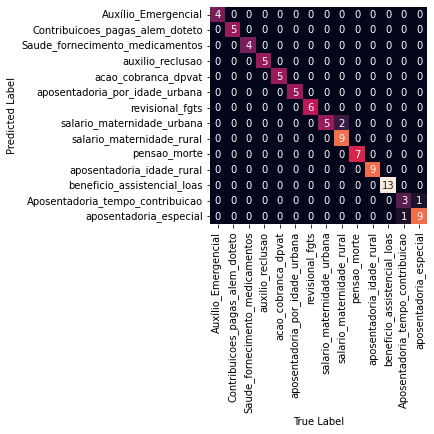

In [59]:
#1. Criar um objeto de pipeline
pipeline_vizinhos_proximos = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer(max_features=650, ngram_range = (1, 3))),    
     ('KNN', KNeighborsClassifier(
         n_neighbors=3, #weights='distance',
         algorithm='kd_tree'
     ))         
])

#2. Ajuste(fit) com X_train e y_train
pipeline_vizinhos_proximos.fit(X_res.flatten(), y_res)


#3. Obter previsões para X_test e armazenar em y_pred
y_pred_vizinhosproximos = pipeline_vizinhos_proximos.predict(X_test)


# imprimir relatório 
print(classification_report(y_test, y_pred_vizinhosproximos))


# Imprime a matriz de confusão 
mat = confusion_matrix(y_test, y_pred_vizinhosproximos)

sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False,
            xticklabels=list(classificacao_peticoes_dicionario.keys()),yticklabels=list(classificacao_peticoes_dicionario.keys()))
plt.xlabel('True Label')
plt.ylabel("Predicted Label")
plt.show()

In [27]:
# Lista de petições e numero de tipos de petições existentes
listOfKeys = classificacao_peticoes_dicionario.keys()
listOfKeys=list(listOfKeys)
print(listOfKeys)
print(len(listOfKeys))

['Auxílio_Emergencial', 'Contribuicoes_pagas_alem_doteto', 'Saude_fornecimento_medicamentos', 'auxilio_reclusao', 'acao_cobranca_dpvat', 'aposentadoria_por_idade_urbana', 'revisional_fgts', 'salario_maternidade_urbana', 'salario_maternidade_rural', 'pensao_morte', 'aposentadoria_idade_rural', 'beneficio_assistencial_loas', 'Aposentadoria_tempo_contribuicao', 'aposentadoria_especial']
14


### **Tentativa 2**: Random Forest

Usando o módulo pipeline sklearn foi criado um pipeline para classificar as petições.

Foi usado TF-IDF para pré-processar o texto.

Foi usado Unigram e Bigrams.

Foi usado **Random Forest** como classificador.


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      0.75      0.86         4
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         6
           7       0.62      1.00      0.77         5
           8       1.00      0.73      0.84        11
           9       0.88      1.00      0.93         7
          10       1.00      1.00      1.00         9
          11       1.00      1.00      1.00        13
          12       0.75      0.75      0.75         4
          13       0.90      0.90      0.90        10

    accuracy                           0.94        93
   macro avg       0.94      0.94      0.93        93
weighted avg       0.95      0.94      0.94        93



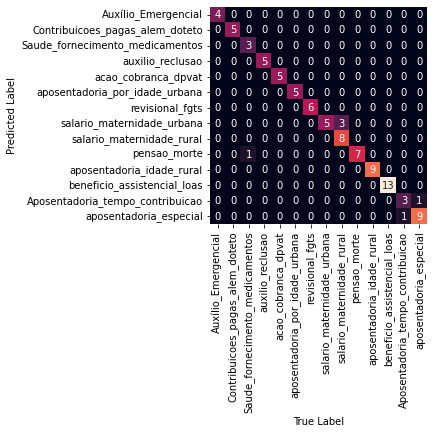

In [58]:
#1. Criar um objeto de pipeline
pipeline_random_forest = Pipeline([
 
    ('vectorizer_tfidf',TfidfVectorizer(max_features=650, ngram_range = (2, 3))),     
     ('Random Forest', RandomForestClassifier(n_estimators=600, min_samples_leaf=2, 
                                              random_state=0, n_jobs=-1))         
])

#2. Ajuste(fit) com X_train e y_train
pipeline_random_forest.fit(X_res.flatten(), y_res)


#3. Obter previsões para X_test e armazenar em y_pred
y_pred_rf = pipeline_random_forest.predict(X_test)

# imprimir relatório 
print(classification_report(y_test, y_pred_rf))

# Imprime a matriz de confusão 
mat = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False,
            xticklabels=list(classificacao_peticoes_dicionario.keys()),yticklabels=list(classificacao_peticoes_dicionario.keys()))
plt.xlabel('True Label')
plt.ylabel("Predicted Label")
plt.show()

### **Tentativa 3**: SVM

Usando o módulo pipeline sklearn foi criado um pipeline para classificar as petições.

Foi usado TF-IDF para pré-processar o texto.

Foi usado Bigrams e Trigrams.

Foi usado **SVM** como classificador.


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         6
           7       0.71      1.00      0.83         5
           8       1.00      0.82      0.90        11
           9       1.00      1.00      1.00         7
          10       1.00      1.00      1.00         9
          11       1.00      1.00      1.00        13
          12       0.50      0.75      0.60         4
          13       0.88      0.70      0.78        10

    accuracy                           0.94        93
   macro avg       0.93      0.95      0.94        93
weighted avg       0.95      0.94      0.94        93



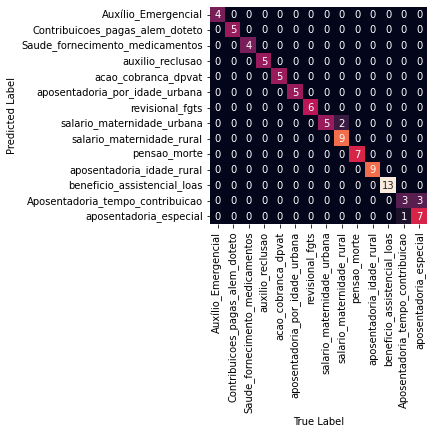

In [29]:
from pandas.core.common import random_state

#1. Criar um objeto de pipeline
pipeline_svc = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer(max_features=650, min_df=13, ngram_range = (2, 3))),        
     ('SVC', SVC(kernel = 'linear', random_state=0))         
])

#2. Ajuste(fit) com X_train e y_train
pipeline_svc.fit(X_res.flatten(), y_res)


#3. Obter previsões para X_test e armazenar em y_pred
y_pred_svm = pipeline_svc.predict(X_test)

# imprimir relatório 
print(classification_report(y_test, y_pred_svm))

# Imprime a matriz de confusão  
mat = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False,
            xticklabels=list(classificacao_peticoes_dicionario.keys()),yticklabels=list(classificacao_peticoes_dicionario.keys()))
plt.xlabel('True Label')
plt.ylabel("Predicted Label")
plt.show()

In [30]:
# print(pipeline_svc['vectorizer_tfidf'].vocabulary_)

### **Tentativa 4**: XGBoost

Usando o módulo pipeline sklearn foi criado um pipeline para classificar as petições. 

Foi usado TF-IDF para pré-processar o texto.

Foi usado Unigrams e Bigrams.

use XGBoost como classificador.



              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.83      1.00      0.91         5
           2       1.00      0.75      0.86         4
           3       1.00      1.00      1.00         5
           4       0.83      1.00      0.91         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         6
           7       0.71      1.00      0.83         5
           8       1.00      0.82      0.90        11
           9       0.86      0.86      0.86         7
          10       0.90      1.00      0.95         9
          11       1.00      0.92      0.96        13
          12       0.40      0.50      0.44         4
          13       0.88      0.70      0.78        10

    accuracy                           0.89        93
   macro avg       0.89      0.90      0.89        93
weighted avg       0.91      0.89      0.89        93



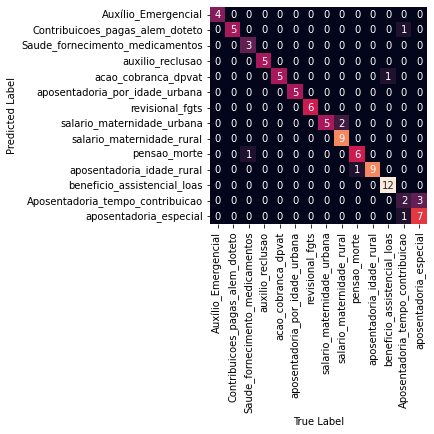

In [31]:

from xgboost import XGBClassifier

#1. Criar um objeto de pipeline
pipeline_xgboost = Pipeline([
  ('vectorizer_tfidf',TfidfVectorizer(max_features=800, min_df=10, ngram_range = (1, 2))),        
     ('xgboost', XGBClassifier(
            learning_rate=0.03,
            n_estimators=500,
            subsample=0.8, 
            colsample_bynode=0.8,
            num_parallel_tree=4
     ))                
])

#2. Ajuste(fit) com X_train e y_train
pipeline_xgboost.fit(X_res.flatten(), y_res)


#3. Obter previsões para X_test e armazenar em y_pred
y_pred_xgboost = pipeline_xgboost.predict(X_test)
     

# Imprime relatório
print(classification_report(y_test, y_pred_xgboost))

# Imprime a matriz de confusão
mat = confusion_matrix(y_test, y_pred_xgboost)

sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False,
            xticklabels=list(classificacao_peticoes_dicionario.keys()),yticklabels=list(classificacao_peticoes_dicionario.keys()))
plt.xlabel('True Label')
plt.ylabel("Predicted Label")
plt.show()

### **Tentativa 5**: ExtraTreesClassifier

Usando o módulo pipeline sklearn foi criado um pipeline para classificar as petições. 

Foi usado TF-IDF para pré-processar o texto.

Foi usado Unigrams e Bigrams.

Foi usado **ExtraTreesClassifier** como classificador.



              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         6
           7       0.83      1.00      0.91         5
           8       1.00      0.91      0.95        11
           9       1.00      1.00      1.00         7
          10       1.00      1.00      1.00         9
          11       1.00      1.00      1.00        13
          12       0.75      0.75      0.75         4
          13       0.90      0.90      0.90        10

    accuracy                           0.97        93
   macro avg       0.96      0.97      0.97        93
weighted avg       0.97      0.97      0.97        93



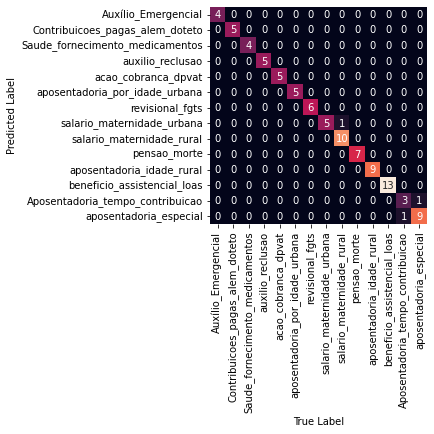

In [32]:
# criação do modelo
from sklearn.ensemble import ExtraTreesClassifier

#1. Criar um objeto de pipeline
pipeline_ExtraTreesClassifier = Pipeline([
  ('vectorizer_tfidf',TfidfVectorizer(max_features=600, min_df=10, ngram_range = (1, 2))),        
     ('ExtraTreesClassifier', ExtraTreesClassifier(
            random_state=0,
            n_estimators=300, 
            max_depth=4,
            min_samples_leaf=1,
     ))                
])

#2. Ajuste(fit) com X_train e y_train
pipeline_ExtraTreesClassifier.fit(X_res.flatten(), y_res)


#3. Obter previsões para X_test e armazenar em y_pred
y_pred_ExtraTreesClassifier = pipeline_ExtraTreesClassifier.predict(X_test)

# Imprime relatório
print(classification_report(y_test, y_pred_ExtraTreesClassifier))

# Imprime a matriz de confusão
mat = confusion_matrix(y_test, y_pred_ExtraTreesClassifier)

sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False,
            xticklabels=list(classificacao_peticoes_dicionario.keys()),yticklabels=list(classificacao_peticoes_dicionario.keys()))
plt.xlabel('True Label')
plt.ylabel("Predicted Label")
plt.show()

## **Utilizando Cross-Validation** <img src="https://cdn-icons-png.flaticon.com/512/8003/8003181.png" width="3%">

Como temos uma base de dados desbalanceadas, vamos utilizar StratifiedKFold ao invés do kfold. 

In [40]:
# Inicializa uma instância de StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kfold

StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [60]:
# Acurácia média para Vizinhos mais próximos

scores = cross_val_score(pipeline_vizinhos_proximos, X, y, cv=kfold, scoring='accuracy')
print(scores)
print(f'Acurácia média: {scores.mean()}')
print(f'Desvio padrão: {scores.std()}')

/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use

[0.88172043 0.84946237 0.89130435 0.85869565 0.91304348]
Acurácia média: 0.8788452547919589
Desvio padrão: 0.022813920242674042


In [ ]:
roc = {label: [] for label in multi_class_series.unique()}
for label in multi_class_series.unique():
    selected_classifier.fit(train_set_dataframe, train_class == label)
    predictions_proba = selected_classifier.predict_proba(test_set_dataframe)
    roc[label] += roc_auc_score(test_class, predictions_proba[:,1])


In [42]:
# Acurácia média para random forest

scores = cross_val_score(pipeline_random_forest, X, y, cv=kfold, scoring='accuracy')
print(scores)
print(f'Acurácia média: {scores.mean()}')
print(f'Desvio padrão: {scores.std()}')

[0.93548387 0.87096774 0.89130435 0.88043478 0.89130435]
Acurácia média: 0.893899018232819
Desvio padrão: 0.022135463309318832


In [43]:
# Acurácia média para SVC

scores = cross_val_score(pipeline_svc, X, y, cv=kfold, scoring='accuracy')
print(scores)
print(f'Acurácia média: {scores.mean()}')
print(f'Desvio padrão: {scores.std()}')

[0.92473118 0.87096774 0.89130435 0.88043478 0.89130435]
Acurácia média: 0.8917484805984106
Desvio padrão: 0.01815539596733294


In [44]:
# Acurácia média para XGBoost

scores = cross_val_score(pipeline_xgboost, X, y, cv=kfold, scoring='accuracy')
print(scores)
print(f'Acurácia média: {scores.mean()}')
print(f'Desvio padrão: {scores.std()}')

[0.93548387 0.87096774 0.90217391 0.86956522 0.91304348]
Acurácia média: 0.8982468443197755
Desvio padrão: 0.025249726923218183


In [45]:
# Acurácia média para ExtraTreesClassifier

scores = cross_val_score(pipeline_ExtraTreesClassifier, X, y, cv=kfold, scoring='accuracy')
print(scores)
print(f'Acurácia média: {scores.mean()}')
print(f'Desvio padrão: {scores.std()}')

[0.80645161 0.79569892 0.80434783 0.79347826 0.80434783]
Acurácia média: 0.8008648901355773
Desvio padrão: 0.005229199698582749


In [46]:
#@title 
# df_peticoes_iniciais.loc[17]['nome_documento']

## **Fazendo Dump** <img src="https://cdn-icons-png.flaticon.com/512/2824/2824710.png" width="3%">

In [ ]:
#@title
# # Fazer upload de petição
# from google.colab import files
# import io, pdftotext
# upload = files.upload()
# filename = list(upload.keys())[0]
# print(filename)

# with open(filename, "rb") as f:
#     pdf = pdftotext.PDF(f)

# texto_documento = "\n\n".join(pdf)
# texto_documento = texto_documento.lower()
# texto_documento = clean_text(texto_documento)
# texto_documento = remove_stopwords(texto_documento)
# #print(texto_documento)

# prediction_teste=predict_category(texto_documento)
# #print(prediction_teste)
# print('Esta petição é sugerida como...')
# if prediction_teste == [0]:
#   print('Aposentadoria por Tempo de Contribuição')
# elif prediction_teste == [1]:
#   print('Aposentadoria Urbana')
# elif prediction_teste == [2]:
#   print('Salario Maternidade Rural')
# elif prediction_teste == [3]:
#   print('Revisional Fgts')
# elif prediction_teste == [4]:
#   print('Pensao po Morte')
# elif prediction_teste == [5]:
#   print('Aposentadoria Idade Rural')
# elif prediction_teste == [6]:
#   print('Aposentadoria Especial')    
# else:
#   print('Beneficio Assistencial Loas')   

     

# def predict_category(s ,model=pipeline_svc):
#     s=remove_header_footer(s)
#     s=clean_text(s)
#     s=remove_stopwords(s)
#     s=stemming(s)
#     pred = model.predict([s])
#     return pred

In [ ]:
# Persistindo o modelo de ML para o disco
import joblib

joblib.dump(pipeline_random_forest, '/content/drive/MyDrive/trf5.peticoes/Random_Forest.pkl')
joblib.dump(pipeline_svc, '/content/drive/MyDrive/trf5.peticoes/SVC.pkl')


['/content/drive/MyDrive/trf5.peticoes/SVC.pkl']

Essa ultima célula é exportando nossos modelos em arquivos .pkl já prontos para aplicação em produção. Foi decidido exportar os modelos de Random Forest e SVC devido a seus bons desempenhos e boa estabilidade na validação cruzada. O trabalho de melhorar cada vez mais o modelo continua ... 

<p align=center>
<img src="https://cdn-icons-png.flaticon.com/512/9375/9375341.png" width="30%"></p>
